# AIPI590, Assignment 3 – Interpretable ML
##### Jason Lee 

In this assignment, we build interpretable models to predict and understand reasons for churn for a telco company. Steps include EDA (data cleaning, assumption testing), fitting and interpreting models, and providing a recommendation on the best model.

The dataset can be found at: https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download.

To use this notebook, please download the CSV file from the link above and upload it to your google colab workspace. You also need to install pygam. Please use the command below to install.

<a target="_blank" href="https://colab.research.google.com/github/choonghwanlee/interpretableml-1-aipi590-f24/blob/main/main.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


In [159]:
%pip install pygam


[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [160]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, classification_report
from pygam import LogisticGAM, GammaGAM, s, f

In [161]:
## we read the churn dataset as a csv file after downloading it from Kaggle: https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download
dataset = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [162]:
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [163]:
## we can drop customerID since it's just an identifier
dataset.drop(columns='customerID', inplace=True)

## Exploratory Data Analysis

### Step 1: Data Cleaning

Key data cleaning procedures include removing/interpolating null values and encoding textual columns  

#### Removing null values

We note that there are no null values in the dataset

In [164]:
## identify columns with null values
null_columns = dataset.columns[dataset.isnull().any()]

# Printing the columns with null values
print("Columns with null values:", null_columns)

Columns with null values: Index([], dtype='object')


#### Text Encoding

There are generally two ways to deal with textual data: label encoding or one-hot encoding.

Label encoding is best suited for 
1. binary columns (# classes = 2) where we can simply encode text values to 0 and 1
2. columns where there is a natural ordering in the values (e.x. month-to-month, one year, two year => 0, 1, 2)

One-hot encoding is best suited for 
1. multi-class columns where the unique values are independent of/orthogonal with each other (e.x. Electronic check, Mailed check, Bank transfer)

In [165]:
## identify text columns 
def fetch_text_col(df):
    text_columns = df.select_dtypes(include='object').columns
    return text_columns

# Print the columns
print(fetch_text_col(dataset))


Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn'],
      dtype='object')


In [166]:
## convert text columns to numbers

def one_hot_encode(df, columns):
    data = df.copy()
    for column in columns:
        one_hot = pd.get_dummies(data[column], drop_first=True)
        data = pd.concat([data, one_hot], axis=1)
        data.drop(column,axis = 1, inplace=True)
    return data 

dataset = one_hot_encode(dataset, ['InternetService', 'PaymentMethod'])

In [167]:
dataset.rename(columns={"No":"NoInternetService"}, inplace=True)

In [168]:
binary_map = {"No": 0, "Yes": 1}

def binary_label_encode(df, columns):
    for column in columns:
        df[column] = df[column].replace(binary_map)
    return df

dataset = binary_label_encode(dataset, ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling','Churn'])
dataset['gender'] = dataset["gender"].replace({"Female": 0, "Male": 1})


In [169]:
dataset['Contract'] = dataset['Contract'].replace({"Month-to-month": 0, "One year": 1, "Two year": 2})

##### The "no phone service" and "no internet service" problem

There is a lot of redundant information in the dataframe. Specifically, if you don't have internet service, that information is represented as an unique value across 7 (!!!) different columns of the dataframe. In other words, 22% of the population have the same value across 7 colmnms. If we one-hot encode these 7 columns, there will be 100% multicollinearity between the one-hot encoded columns corresponding to "no internet service". There are two solutions:

1. Drop 6 of the redundant columns and retain only one one-hot encoded column representing possession of internet service
2. Instead of one-hot encoding all 7 columns, map "No Internet Service" to "No" for all columns other than InternetService to create a binary column we can label encode. We only one hot encode InternetService to create a single column that encodes information about possession of internet service.

We choose Option 2 since it has less dimensionality than Option 1 without sacrificing the total amount of information encoded (e.x. for Online Security – whether the customer has online security or not – mapping No Internet Service to No makes perfect sense because people with no internet service can't have online security, etc.). Using the same logic, we use Option 2 for PhoneService and MultipleLines

In [170]:
## Dealing with no phone service
dataset['MultipleLines'] = dataset['MultipleLines'].replace({"No phone service": 0, "No": 0, "Yes": 1})

In [171]:
## Dealing with no internet service

# Step 1: Replace values in other columns when InternetService is 0
no_internet = dataset['NoInternetService'] == 1

# Apply "No" to other columns where InternetService is "No"
columns_to_update = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
dataset.loc[no_internet, columns_to_update] = 'No'

# We label encode the other columns. InternetServie was already one-hot encoded from before
dataset = binary_label_encode(dataset, columns_to_update)

In [172]:
print(fetch_text_col(dataset))

Index(['TotalCharges'], dtype='object')


In [173]:
def convert_to_float(value):
    try:
        return float(value)
    except ValueError:
        return 0.0

dataset['TotalCharges'] = dataset['TotalCharges'].apply(convert_to_float)

In [174]:
print(fetch_text_col(dataset))

Index([], dtype='object')


In [175]:
## we obtain the list of all features
features = [column for column in dataset.columns if column != 'Churn']

In [176]:
# we obtain the list of all continuous and discrete features
numerical = [column for column in features if dataset[column].nunique() > 3]
categorical = [column for column in features if dataset[column].nunique() <= 3]

### Step 2: Testing Assumptions

We test assumptions of linear and logistic regression below. We assume independence in observations since we do not know how the data was collected, and that the sample size is large enough since we do not know the total number of customers of this telco company

#### Building a simple model:

To test for certain assumptions (especially those that deal with residuals), it is necessary to build a basic model to generate predictions. we build a simple linear regression & logistic regression model on the entire dataset to test assumptions related to homoscedasticity, normality, and autocorrelation of our data at large

Keep in mind that we fit the model to our entire dataset, but later, we will generate a final model after train test split

In [177]:
linear_reg = LinearRegression().fit(dataset[features], dataset['Churn'])
logistic_reg = LogisticRegression(random_state=0).fit(dataset[features], dataset['Churn'])

#### Linearity (Linear Regression, Logistic Regression)

We want to test for linear dependence beteween our input and target. This means different things in linear regression and logistic regression. In linear regression, we are simply observing the linear correlation between an input and continuous output variable. In logistic regression, we test for linearity between an input and the log probability of the predicted output. 

For linear regression, we treat churn as a continuous variable and simply visualize a heatmap of pearson correlation. We note that there are only a few variables with strong pearson correlation with churn. We conclude that the linearity assumption is not met.

For logistic regression, we first use our naively fitted logistic regression model to generate log probabilities (logits), then either plot a scatterplot for continuous inputs or a box plot for categorical inputs. We conclude that tenure and monthly charges have linear relationships, in addition to contract, electronic check, Fiber Optics, no internet service, etc. However, other columns exhibit little association with Churn. This indicates that there may not be a linear relationship

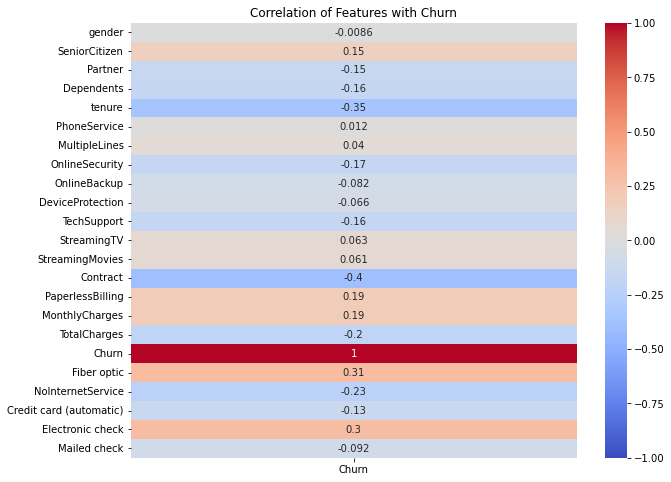

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate Pearson correlation between all features and the target variable
correlation_matrix = dataset.corr(method='pearson')

# Select only the target correlations
target_correlation = correlation_matrix[['Churn']]

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(target_correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of Features with Churn')
plt.show()


In [179]:
def plot_feature_vs_logits(model, X, continuous_features, discrete_features):
    # Get logits from the model using predict_log_proba
    logits = model.predict_log_proba(X)[:, 1]  # Assuming binary classification, logits for the positive class
    
    # Convert X to DataFrame
    X_df = pd.DataFrame(X, columns=continuous_features + discrete_features)
    
    # Add logits to the DataFrame
    X_df['logits'] = logits
    
    # Create subplots with two columns
    num_continuous = len(continuous_features)
    num_discrete = len(discrete_features)
    total_plots = num_continuous + num_discrete
    num_rows = (total_plots + 1) // 2
    
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten axes array to make indexing easier
    
    # Plot scatterplots for continuous features
    for i, feature in enumerate(continuous_features):
        sns.scatterplot(x=X_df[feature], y=X_df['logits'], ax=axes[i])
        axes[i].set_title(f'Scatterplot of {feature} vs Logits')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Logits')
    
    # Plot boxplots for discrete features
    for i, feature in enumerate(discrete_features):
        sns.boxplot(x=X_df[feature], y=X_df['logits'], ax=axes[num_continuous + i])
        axes[num_continuous + i].set_title(f'Boxplot of {feature} vs Logits')
        axes[num_continuous + i].set_xlabel(feature)
        axes[num_continuous + i].set_ylabel('Logits')
    
    # Remove any unused subplots
    for j in range(total_plots, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()



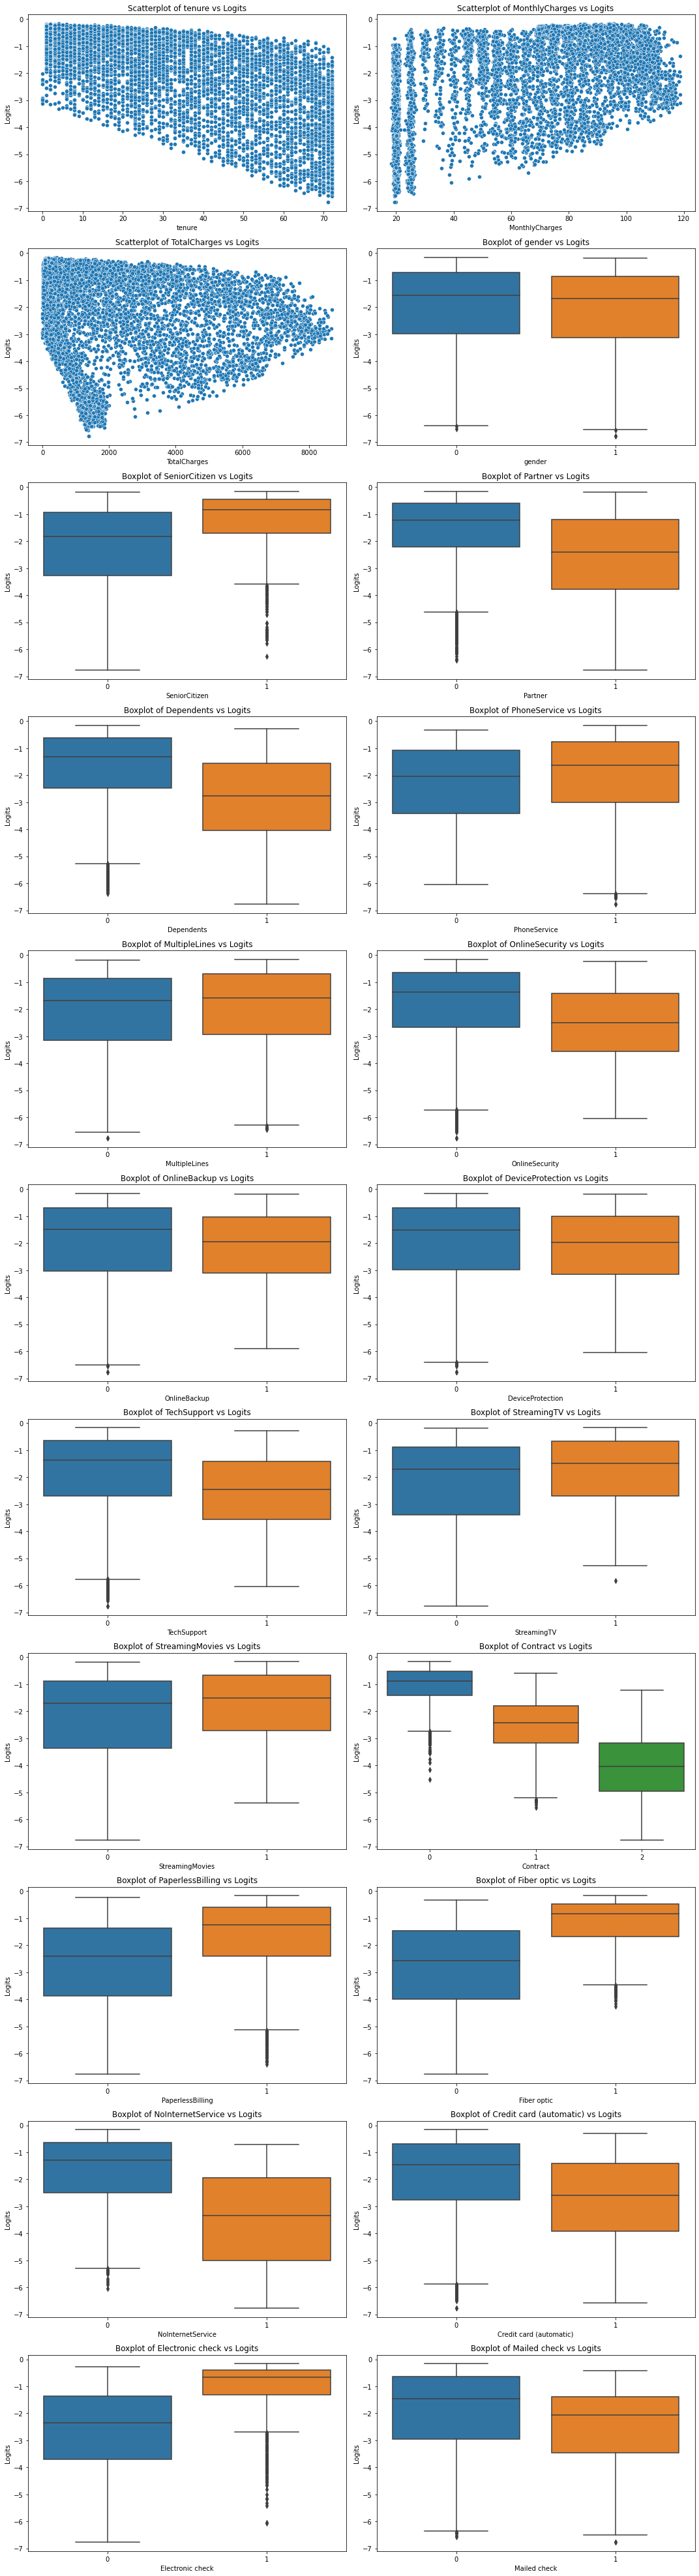

In [180]:
plot_feature_vs_logits(logistic_reg, dataset[features], numerical, categorical)

### Multicollinearity (Linear, Logistic Regression, GAMs)

To test for multicollinearity, we use VIF (Variance Inflation Factor) in addition to a seaborn heatmap of correlation as visual aid.

We adopt the code below from https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/

Results show that multicollinearity assumption is violated by MonthlyCharges, which has a VIF > 100

In [181]:
def multicollinearity_assumption(features, feature_names=None):

    # Plotting the heatmap
    plt.figure(figsize = (10,8))
    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')


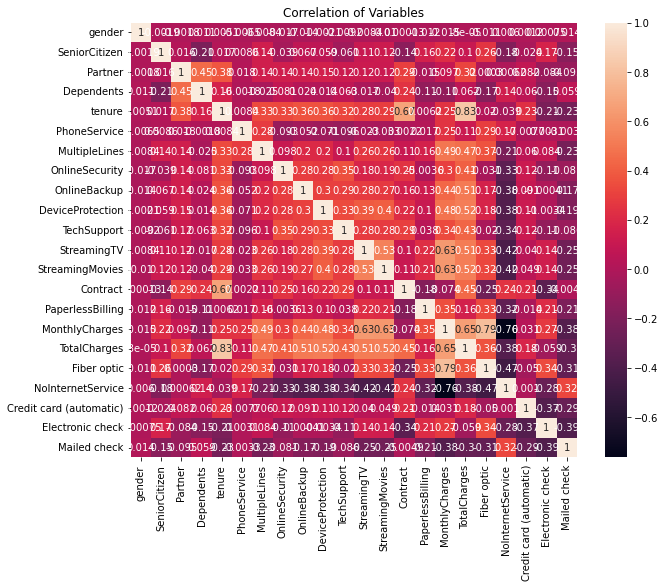

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
gender: 2.021455663601127
SeniorCitizen: 1.3760559999156667
Partner: 2.82715285128556
Dependents: 1.976228965986267
tenure: 20.266290907847498
PhoneService: 47.09922458833395
MultipleLines: 2.8399499383748346
OnlineSecurity: 2.6853374648227963
OnlineBackup: 2.907759893877303
DeviceProtection: 2.9947775152682943
TechSupport: 2.7591185572987342
StreamingTV: 4.927033331174704
StreamingMovies: 5.073976161388576
Contract: 4.216134448820494
PaperlessBilling: 2.9536017123870275
MonthlyCharges: 211.16381289170158
TotalCharges: 21.241866871850824
Fiber optic: 17.575981882317382
NoInternetService: 8.193779935388195
Credit card (automatic): 1.9833995985504684
Electronic check: 2.952886234323984
Mailed check: 2.390170946865661

5 cases of possible multicollinearity
1 cases of definite multicollinearity

Assumption not 

In [182]:
multicollinearity_assumption(dataset[features], features)

### Homoscedasticity (Linear Regression)

Homoscedasticity measures the variance in residual terms. Specifically, we want an even variance across our residual terms. 

Sourcing code from https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/, we implement a function to calculate residuals, then to test homoscedasticity from it.

We note that the residual is relatively constant across the board, indicating that homoscedasticity is satisfied

In [183]:
def calculate_residuals(model, features, label):
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results


In [184]:
def homoscedasticity_assumption(model, features, label):

    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()  


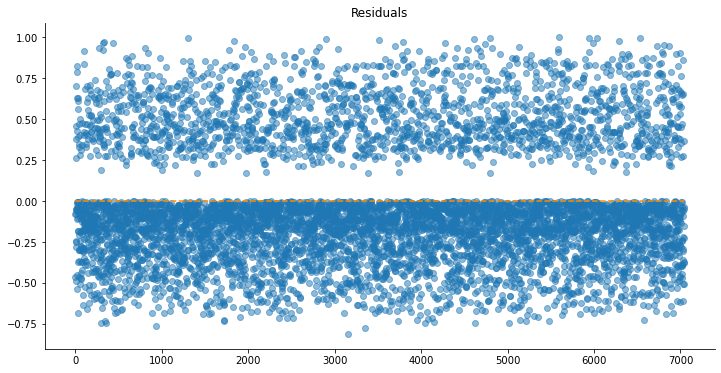

In [185]:
homoscedasticity_assumption(linear_reg, dataset[features], dataset['Churn'])

#### Normality of the Error Terms (Linear Regression)

In linear regression, we want the error terms (residuals) to be normally distributed. The Anderson-Darling test is suited for assessing normality. We will also plot the distribution of residuals for visual aid.

Code is sourced from: https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/ 

The test shows that the residuals are not normally distributed, since the p-value is 0 and a p-value of less than 0.05 means non-normality. This is evidenced by the distribution plot 

In [186]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')


Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


/Users/choonghwanlee/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


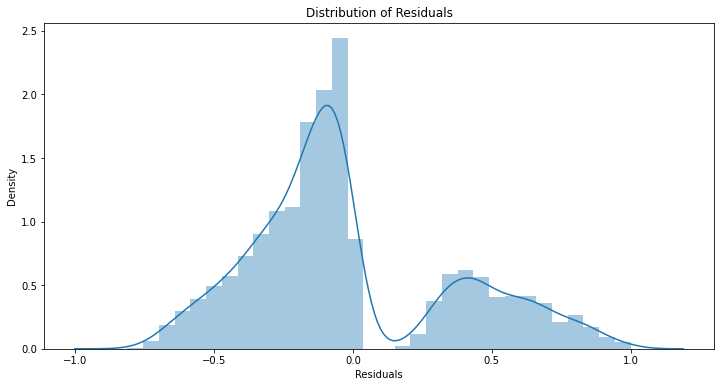


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


In [187]:
normal_errors_assumption(linear_reg, dataset[features], dataset['Churn'])

#### Autocorrelation (Linear Regression)

Autocorrelation indicates that residuals are correlated over time. To satisfy assumptions of linear regression, there should be no autocorrelation. The Durbin-Watson test is perfect for testing autocorrelation, with a score <1.5 or > 2.5 indicative of autocorrelation.

We source code from https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/

Results indicate that the autocorrelation assumption is satisfied

In [188]:
def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')


In [189]:
autocorrelation_assumption(linear_reg, dataset[features], dataset['Churn'])



Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.9950649473957898
Little to no autocorrelation 

Assumption satisfied


#### Outliers (Logistic Regression)

Logistic regression assumes that there are no influential outliers in the model. To test this, we use a simple boxplot of all the numerical features in our datset

Based on the boxplot, we see no influential outliers (e.x. points beyond the whisker). We can conclude that the outliers assumption is met

In [190]:

def plot_boxplots(data: pd.DataFrame, columns: list):
    """
    Plots boxplots for specified columns in the given DataFrame.

    Args:
    - data (pd.DataFrame): The dataset containing the columns.
    - columns (list): List of column names for which to plot boxplots.

    Returns:
    - None
    """

    # Create a figure with subplots
    num_rows = len(columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(10, 5 * num_rows))

    # Plot boxplots for each column
    for i, col in enumerate(columns):
        sns.boxplot(data=data, x=col, ax=axes[i])
        axes[i].set_title(f'Boxplot of {col}')
    
    plt.tight_layout()
    plt.show()


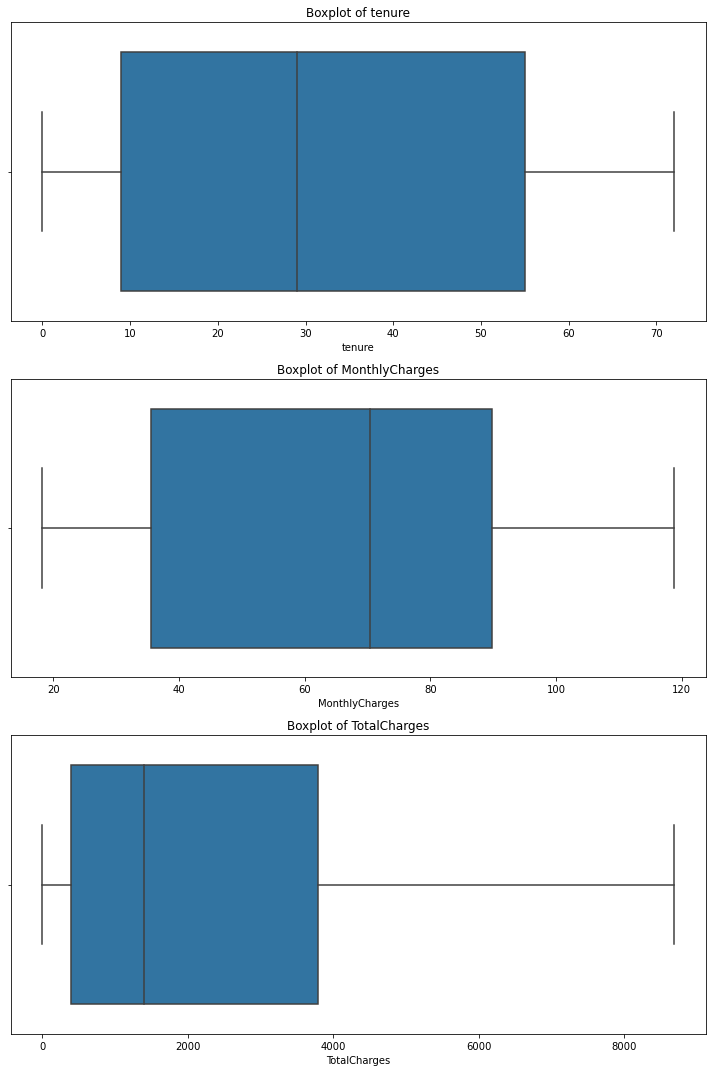

In [191]:
plot_boxplots(dataset, numerical)

## Model Implementation & Interpretation

### Train-Test Split

We train test split with scikit-learn using a 1/3 test split

In [192]:
X_train, X_test, y_train, y_test = train_test_split(dataset[features], dataset['Churn'], test_size = 0.33, random_state = 0)

### Linear Regression

We fit a linear regression model on our train data and create a barplot of its coefficients. In linear regression, an increase in an independent variable by a factor of 1 indicates a beta increase in churn, where beta is the weight associated with the independent variable.

We note that the most influential features are whether you have a phone service or not (having a phone service decreases churn), whether you use electronic check (using electronic check increases churn), and whether you have online security (having online security decreases churn).

The model has a Mean Squared Error of 0.14, which is slightly high considering the range of expected values are simply between 0 and 1 

In [193]:
# Fitting the model
linear_reg = LinearRegression().fit(X_train, y_train)

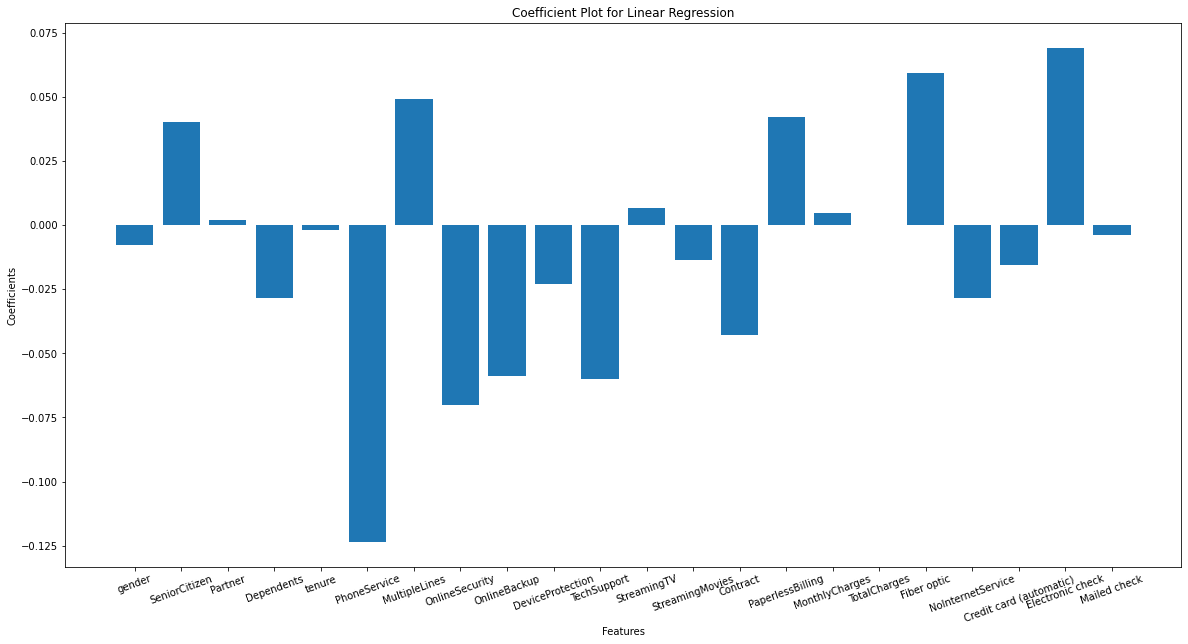

In [194]:
# Get the coefficients (weights)
coefficients = linear_reg.coef_

# Create a bar plot of the coefficients
plt.figure(figsize=(20, 10))
plt.bar(features, coefficients)
plt.xlabel("Features")
plt.xticks(rotation=20)
plt.ylabel("Coefficients")
plt.title("Coefficient Plot for Linear Regression")
plt.show()


In [195]:
## Evaluating the model

y_pred = linear_reg.predict(X_test)
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))

Mean Squared Error:  0.14309805387359092


### Logistic Regression

We fit a logistic regression model to our training data and examine the coefficients. In this case, an increase in an independent variable by a factor of 1 corresponds to a beta incresae in the log odds of churn, where beta is the weight associated with the independent variable. 

We note that the most influential factors change slightly. For example, having phone service or having internet service decreases the log odds of churn by ~0.5 to ~0.6 and longer contract terms lead to a ~0.8 decrease in log odds of churn. Having Fiber Optics leads to a ~0.4 incresae in log odds of churn.

However, it's important to note that the model does not do a great job of predicting the positive class (people who churn), with a F1 score of 0.59 as opposed to an F1 score of 0.87 for predicting no churn. This is likely due to class imbalance.

In [196]:
dataset['Churn'].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

In [197]:
logistic_reg = LogisticRegression(random_state=0).fit(X_train, y_train)


/Users/choonghwanlee/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


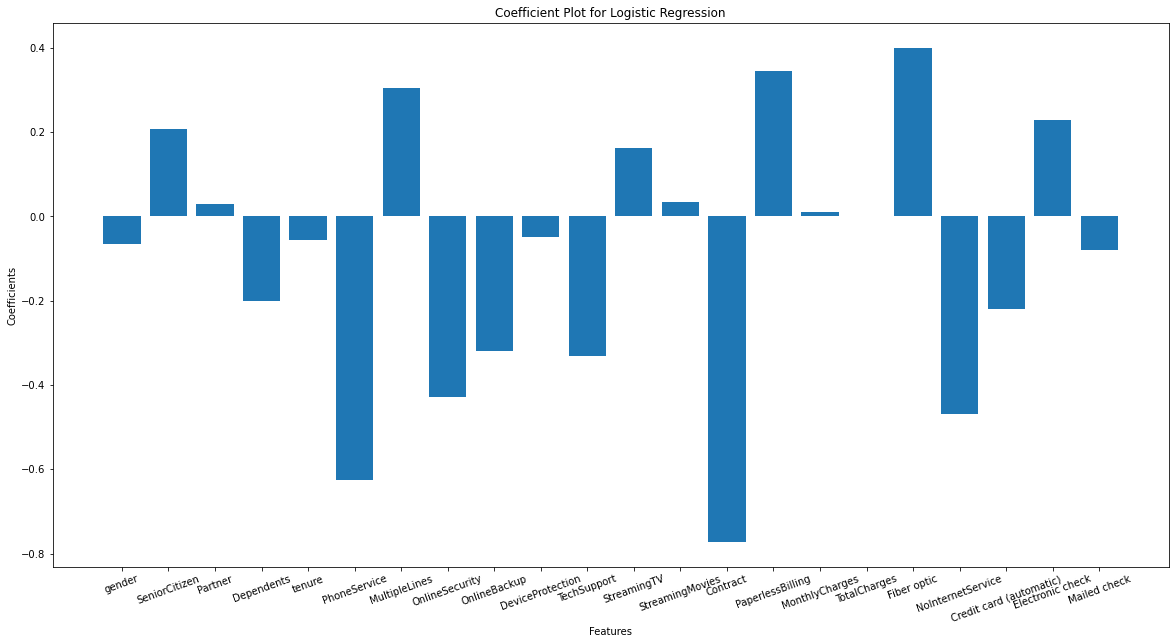

In [198]:
# Get the coefficients (weights)
coefficients = logistic_reg.coef_[0]

# Create a bar plot of the coefficients
plt.figure(figsize=(20, 10))
plt.bar(features, coefficients)
plt.xlabel("Features")
plt.xticks(rotation=20)
plt.ylabel("Coefficients")
plt.title("Coefficient Plot for Logistic Regression")
plt.show()


In [199]:
y_pred = logistic_reg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1712
           1       0.65      0.55      0.59       613

    accuracy                           0.80      2325
   macro avg       0.75      0.72      0.73      2325
weighted avg       0.79      0.80      0.80      2325



### Generalized Additive Models

We leverage the PyGAM module to implement GAM. Specifically, we use LogisticGAM, which uses a binomial error distribution, and a logit link. With just linear terms, this would be logistic regression. Instead, we use a spline term for continuous variables and a factor term for all discrete, categorical columns.

We use the partial dependence plot to examine how each input feature affects the output. Partial Dependence Plots (PDPs) show the marginal effect of one feature on the predicted outcome. The partial function tells us what the average marginal effect on the prediction is for given value(s) of a feature S. Among continuous features, tenure seems to have the strongest influence. Among categorical features, length of contract term, use of Fiber Optic, use of phone service, use of multiple lines, and use of internet service are influential factors (magnitude >0.25).

We note the same issue with logistic regression where the F1 score is markedly worse for predicting churn. The lack of improvement in the model is presumably due to the fact that there aren't many continuous variables in the feature set to model non-linear relationships for to begin with

In [200]:
for index, name in enumerate(features):
    print(f"{index}, {name}")

0, gender
1, SeniorCitizen
2, Partner
3, Dependents
4, tenure
5, PhoneService
6, MultipleLines
7, OnlineSecurity
8, OnlineBackup
9, DeviceProtection
10, TechSupport
11, StreamingTV
12, StreamingMovies
13, Contract
14, PaperlessBilling
15, MonthlyCharges
16, TotalCharges
17, Fiber optic
18, NoInternetService
19, Credit card (automatic)
20, Electronic check
21, Mailed check


In [201]:
## implementation of LogisticGAM
gam = LogisticGAM(f(0) + f(1) + f(2) + f(3) + s(4) 
+ f(5) + f(6) + f(7) + f(8) + f(9) + f(10) + f(11) + f(12) + f(13) + f(14) 
+ s(15) + s(16) + f(17) + f(18) + f(19) + f(20) +f(21)).fit(X_train, y_train)

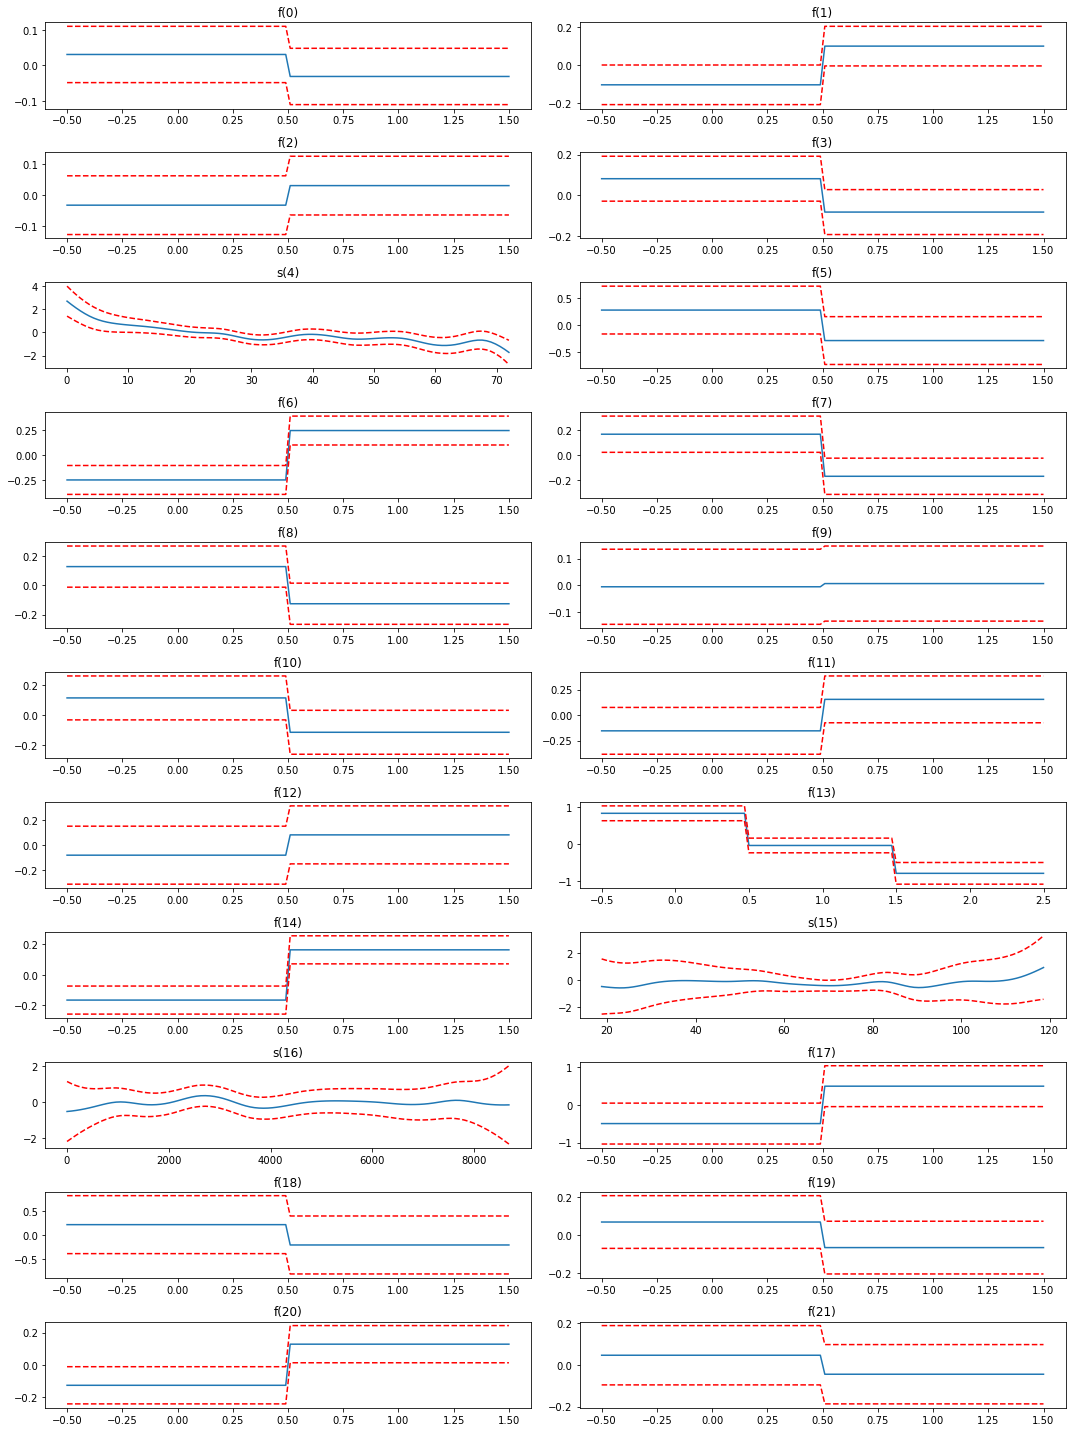

In [202]:
fig, axs = plt.subplots(11, 2, figsize=(15, 20))
axs = axs.flatten()  # Flatten the 2D array of axes for easier iteration

for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    ax = axs[i]
    ax.plot(XX[:, term.feature], pdep)
    ax.plot(XX[:, term.feature], confi, c='r', ls='--')
    ax.set_title(repr(term))
plt.tight_layout()  # Adjust the layout to avoid overlapping elements
plt.show()

In [203]:
y_pred = gam.predict(X_test)
print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1712
           1       0.64      0.54      0.59       613

    accuracy                           0.80      2325
   macro avg       0.74      0.72      0.73      2325
weighted avg       0.79      0.80      0.79      2325



## Conclusion

### Strength and Weakness Analysis 

Linear Regression:
1. Strengths: very interpretable coefficients, simple to understand
2. Weaknesses: linear regression is not suited for binary classification tasks. The output is not bounded. Any input data that is outside of the current data distribution will lead to non-sensical outputs

Logistic Regression:
1. Strengths: still very interpretable, outputs are constrained as probabilities instead of continuous output
2. Weaknesses: difficulty working with imbalanced data (low F1 score)

Logistic GAM:
1. Strengths: allows us to measure non-linear relationships in the data
2. Weaknesses: slightly less interpretable + no marked improvement in performance

### Recommendation

Based on our analysis, we recommend logistic regression as the model to adopt to examine churn. Linear Regression is just not the right type of model in this case, while Logistic GAM does not offer marked performance gains, presumably because there aren't many continuous features to model a spline function for to begin with. Logistic Regression remains simple and interpretable. However, there is a need to address the class imbalance problem and improve the performance on the positive class before weights are re-examined to diagnose reasons for churn